<a href="https://colab.research.google.com/github/YaninaK/anomaly-detection/blob/b1/notebooks/03_Sequence_anomalies_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обнаружение аномалий в начислениях за тепловую энергию


## 3. Cнижение/рост показаний в отдельные месяцы по сравнению с показаниями за предыдущие периоды по данному объекту

(с учётом фактической температуры наружного воздуха и количества отопительных дней в месяце).

### Примеры аномалий

Виды аномалий по показаниям приборов учёта тепловой энергии, которые необходимо выявлять (кроме объектов с видом энергопотребления ГВС (централ):

1. нулевые значения показаний за тепловую энергию в отопительный период (октябрь-апрель);

2. равные значения показаний в течение нескольких расчетных периодов;

3. снижение/рост показаний в отдельные месяцы по сравнению с показаниями за предыдущие периоды по данному объекту (с учётом фактической температуры наружного воздуха и количества отопительных дней в месяце);

4. аномально низкое/высокое (отклонение более 25%) потребление объекта в конкретном месяце по сравнению с аналогичными объектами (только для типов объекта «Многоквартирный дом») по критериям:
  - год постройки (по группам до 1958 г., 1959-1989 гг., 1990-2000 гг., 2001-2010 гг., 2011-2024 гг.),
  - этажность (по группам 1-2 этажа, 3-4 этажа, 5-9 этажей,10-12 этажей, 13 и более этажей),
  - площадь (±10%),
  - наличие ГВС ИТП (горячей воды, учитываемой тем же прибором).

In [1]:
initiate = False
if initiate:
  !git init -q
  !git clone -b b1  https://github.com/YaninaK/anomaly-detection.git -q

  from google.colab import drive
  drive.mount('/content/drive')

  !unzip -u -q /content/drive/MyDrive/ML_projects/08_anomaly_detection/data/01_raw/task#3.zip -d /content/anomaly-detection/data/01_raw

%cd /content/anomaly-detection

/content/anomaly-detection


In [2]:
import os
import sys

sys.path.append(os.getcwd())
sys.path.append(os.path.join(os.getcwd(), "src", "anomaly_detection"))

In [3]:
import datetime
import random
import tempfile

import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

from data.make_dataset import load_data
from data.preprocess import Preprocess
from data.data_sequence import generate_data_sequence
from features.objects_grouping import ObjectsGrouping
from features.model_inputs import Generator

from models.LSTM_model import get_model
from models.inference_results import post_process_inference_results
from models.utilities import plot_loss, plot_metrics

In [4]:
import warnings
warnings.filterwarnings('ignore')

## 1. Чтение данных

In [5]:
%%time
save = False
data, temperature, buildings = load_data(save=save)

CPU times: user 1.4 s, sys: 62 ms, total: 1.46 s
Wall time: 2.39 s


## 2. Подготовка данных

In [6]:
preprocess = Preprocess()
data, buildings, temperature = preprocess.fit_transform(data, buildings, temperature)

data.shape

(75385, 10)

In [7]:
%%time
df = generate_data_sequence(data)

print(f"df.shape = {df.shape}\n")
df.sample(2)

df.shape = (4628, 24)

CPU times: user 801 ms, sys: 5.7 ms, total: 806 ms
Wall time: 822 ms


,,,,,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,...,2022-09-01,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01,2023-03-01,2023-04-01,2023-05-01,2023-06-01
Адрес объекта,Тип объекта,№ ОДПУ,Вид энерг-а ГВС,Адрес объекта 2,,,,,,,,,,,,,,,,,,,,,
"г Уфа, ул. Энтузиастов, д.5",Многоквартирный дом,26906,0,"г Уфа, ул. Энтузиастов, д.5",NaN,NaN,0.0,59.37,102.58,129.54,186.117,79.095,136.180,92.188,...,NaN,48.7270,115.888,165.695,184.254,151.7420,104.690,58.680,NaN,NaN
"г Уфа, ул. им Фронтовых бригад, д.9",Многоквартирный дом,72558,0,"г Уфа, ул. им Фронтовых бригад, д.9",NaN,NaN,NaN,67.54,99.60,131.61,NaN,NaN,136.915,102.663,...,NaN,109.6327,101.902,151.684,162.381,136.4933,107.335,80.639,NaN,NaN


In [8]:
temperature.sample(2)

Период,"Тн.в, град.С",ОЗП,Число дней
index,,,
2021-09-01,25.000000,0,32.0
2023-01-01,-12.745161,1,31.0


In [9]:
n_periods = len(df)
df.iloc[:, -n_periods:] = np.where(
    df.iloc[:, -n_periods:] == 0, np.nan, df.iloc[:, -n_periods:]
)
print(f"df.shape = {df.shape}\n")
df.sample(2)

df.shape = (4628, 24)



,,,,,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,...,2022-09-01,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01,2023-03-01,2023-04-01,2023-05-01,2023-06-01
Адрес объекта,Тип объекта,№ ОДПУ,Вид энерг-а ГВС,Адрес объекта 2,,,,,,,,,,,,,,,,,,,,,
"г Уфа, ул. Блюхера, д.3 корп.3",Многоквартирный дом,147358,1,"г Уфа, ул. Блюхера, д.3 корп.3",14.301,14.609,18.032,81.161,142.511,162.174,220.763,172.270,140.350,106.161,...,24.002,76.896,140.697,192.623,223.166,188.412,131.788,72.738,20.996,20.218
"г Уфа, ул. 8 Марта, д.34",Многоквартирный дом,1111922,1,"г Уфа, ул. 8 Марта, д.34",31.741,44.039,43.414,173.992,244.408,282.467,333.623,270.799,287.253,227.100,...,48.428,152.055,200.895,341.410,377.871,329.834,292.874,187.129,42.808,54.049


## 3. Сопоставление данных о потребленнии теплоэнергии и данных об объектах

### 3.1 Более одного объекта на одном ```№ ОДПУ```

In [10]:
df_comb = (
    buildings.merge(
        df.reset_index(),
        left_on=["Тип Объекта", "Адрес объекта 2"],
        right_on=["Тип объекта", "Адрес объекта 2"],
        how="right",
    )
    .drop_duplicates(
        subset=["Адрес объекта_y", "Тип объекта", "№ ОДПУ", "Вид энерг-а ГВС"],
        keep=False,
    )
)
df_comb.shape[0] - df.shape[0]

-74

* У 74 объектов типа ```Другое строение```  на один ```№ ОДПУ``` привязано более одного объекта разной этажности. Эти объекты исключены из обучающей выборки.

### 3.2 Отсутствуют данные об объектах

In [11]:
selected = ["Адрес объекта", "Тип объекта", "№ ОДПУ", "Вид энерг-а ГВС"]
(
    df_comb[df_comb["Адрес объекта_x"].isnull()]
    .rename(columns={"Адрес объекта_y": "Адрес объекта"})[selected]
    .sort_values(by=["Тип объекта", "Адрес объекта"])
    .reset_index(drop=True)
)

,Адрес объекта,Тип объекта,№ ОДПУ,Вид энерг-а ГВС
0,"г Уфа, ул. Новоженова, д.88 корп.литер 1, Подо...","Административные здания, конторы",255257,0
1,г Уфа,Другое строение,787,1
2,"г Уфа, пр-кт Октября, д.18 корп.3а",Другое строение,247280,0
3,"г Уфа, ул. Войкова, д.2",Другое строение,103243,0
4,"г Уфа, ул. Дмитрия Донского, д.1 корп.4",Другое строение,189082,0
5,"г Уфа, ул. Кислородная, д.7, Подобъект №983475",Другое строение,1600800,0
6,"г Уфа, ул. Кулибина, д.40",Другое строение,1108050,0
7,"г Уфа, ул. Максима Горького, д.69 корп.1",Другое строение,98266,0
8,"г Уфа, ул. Николая Дмитриева, д.19 корп.1",Другое строение,1544202,0
9,"г Уфа, ул. Пархоменко, д.125",Другое строение,1668,0


* У 24 объектах из данных о потреблении теплоэнергии отсутствуют данные в базе объектов. Эти объекты исключены из обучающей выборки

In [12]:
df_comb = df_comb[df_comb["Адрес объекта_x"].notnull()].reset_index(drop=True)

df_comb.shape[0] - df.shape[0]

-98

In [13]:
df_comb.shape

(4530, 34)

## 4. Формирование обучающей и тестовой выборки

### 4.1 Формирование датасета

In [14]:
df_stat = df_comb[
    [
        "Адрес объекта 2",
        "Тип объекта",
        "№ ОДПУ",
        "Вид энерг-а ГВС",
        "Этажность объекта",
        "Дата постройки",
        "Общая площадь объекта",
    ]
]
df_stat.sample(2)

,Адрес объекта 2,Тип объекта,№ ОДПУ,Вид энерг-а ГВС,Этажность объекта,Дата постройки,Общая площадь объекта
3565,"г Уфа, ул. Российская, д.163",Многоквартирный дом,107182,0,9.0,1982-01-01,3787.6
3461,"г Уфа, ул. Рихарда Зорге, д.48 корп.2",Многоквартирный дом,16027226,1,5.0,1966-01-01,3563.6


In [15]:
n_periods = 24
df_seq = df_comb.iloc[:, -n_periods:] / temperature["Число дней"]

df_seq.sample(2)

,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,...,2022-09-01,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01,2023-03-01,2023-04-01,2023-05-01,2023-06-01
3655,NaN,NaN,NaN,1.256759,1.298097,1.805767,2.227548,1.816286,1.497774,0.920088,...,NaN,1.632963,1.107806,1.614907,1.585194,1.491034,1.159067,0.844969,NaN,NaN
84,0.339516,0.116452,0.471375,1.550000,2.359355,3.051167,3.561968,3.440179,3.252452,2.184324,...,0.324074,1.839889,2.548742,4.102753,3.975645,3.812487,2.820733,1.987719,0.440843,0.3807


### 4.2 Выбор длины последовательности

In [16]:
def get_max_sequence_length(x):
  max_length = 0
  current_length = 0
  for number in x:
    if np.isnan(number):
      current_length = 0
    else:
      current_length += 1
    if current_length > max_length:
        max_length = current_length

  return max_length

In [17]:
n = df_seq.shape[0]
seq_length = df_seq.T.apply(get_max_sequence_length)
print(f"Всего {n} объектов")
print(f"Потеря объектов обучающей выборки при длине непрерывной последовательности:")
for i in range(3, 8):
  print(f"{i}: {n - df_seq[seq_length >= i].shape[0]}")

Всего 4530 объектов
Потеря объектов обучающей выборки при длине непрерывной последовательности:
3: 131
4: 201
5: 271
6: 358
7: 509


* Оптимальная длина последовательности - 4: по трем точкам будем предсказвыать четвертую.

In [18]:
seq_length = 4

### 4.3 Создание обучающей, тестовой и валидационной выборок

* Для тестирования модели оставим 4 месяца: два - в отопительный сезон, два - за пределами отопительного сезона.
* Для валидации - один месяц.

In [19]:
t, v = 4, 1
train = df_seq.iloc[:,:-t-v]
valid = df_seq.iloc[:, -t-v-seq_length+1:-t]
test = df_seq.iloc[:,-t-seq_length+1:]


print(f"Обучающая выборка с{train.columns[0]: '%Y-%m'}до{train.columns[-1]: '%Y-%m'}")
print(f"Валидационная выборка с{valid.columns[0]: '%Y-%m'}до{valid.columns[-1]: '%Y-%m'}")
print(f"Тестовая выборка с{test.columns[0]: '%Y-%m'}до{test.columns[-1]: '%Y-%m'}\n")

train.shape, valid.shape, test.shape

Обучающая выборка с '2021-07'до '2023-01'
Валидационная выборка с '2022-11'до '2023-02'
Тестовая выборка с '2022-12'до '2023-06'



((4530, 19), (4530, 4), (4530, 7))

### 4.4. Нормализация температуры

In [20]:
temperature["t_scaled"] = np.nan
t_ = temperature["Тн.в, град.С"].values.reshape(-1, 1)
scaler = MinMaxScaler()
temperature.iloc[:-t, -1] = scaler.fit_transform(t_[:-t])
temperature.iloc[-t:, -1] = scaler.transform(t_[-t:])
temperature.sample(3)

Период,"Тн.в, град.С",ОЗП,Число дней,t_scaled
index,,,,
2023-01-01,-12.745161,1,31.0,0.000000
2022-05-01,25.000000,0,27.0,1.000000
2022-02-01,-6.735714,1,28.0,0.159211


### 4.5. Cтатические признаки

In [21]:
grouping = ObjectsGrouping()
df_stat = grouping.fit_transform(df_stat)

df_stat.sample(2)

,Адрес объекта 2,Тип объекта,№ ОДПУ,Вид энерг-а ГВС,Этажность объекта,Дата постройки,Общая площадь объекта,Группа этажность объекта,Улица,Дата постройки 2,Группа год постройки,Группа общая площадь объекта
3979,"г Уфа, ул. Ульяновых, д.24",Многоквартирный дом,106654,0,5.0,1962-01-01,3263.4,5-9 этажей,ул. Ульяновых,1962-01-01,1959-1989 гг.,3400
2152,"г Уфа, ул. Комсомольская, д.15",Многоквартирный дом,214683 214962 224503,1,23.0,2013-01-01,59310.4,13 и более этажей,ул. Комсомольская,2013-01-01,2011-2024 гг.,65000


### 4.6. Tensorflow dataset

In [22]:
%%time
generator = Generator()
ds_train, train_df = generator.fit_transform(train, temperature, df_stat)
ds_valid, valid_df = generator.fit_transform(valid, temperature, df_stat)
ds_test, test_df = generator.fit_transform(test, temperature, df_stat)

CPU times: user 16.2 s, sys: 424 ms, total: 16.6 s
Wall time: 16.7 s


In [23]:
ds_train.batch(1).take(1)

<_TakeDataset element_spec=({'n_floors': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'area': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'area_group': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'object_type': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'floor_group': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'year_group': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'street': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'gvs': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'LSTM input': TensorSpec(shape=(None, 4, 3), dtype=tf.float64, name=None)}, TensorSpec(shape=(None, 4, 3), dtype=tf.float64, name=None))>

In [24]:
#next(iter(ds_train.take(1)))
#list(ds_train.as_numpy_iterator())

## 5. Автоэнкодер

In [25]:
model = get_model(df_stat, model_type="autoencoder")
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ object_type (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street (InputLayer)       │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ object_type_prep          │ (None, 1)              │              0 │ object_type[0][0]      │
│ (StringLookup)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street_prep               │ (None, 1)              │              0 │ street[0][0]           │
│ (StringLookup)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ object_type_emb           │ (None, 1, 5)           │            110 │ object_type_prep[0][0] │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street_emb (Embedding)    │ (None, 1, 15)          │          3,315 │ street_prep[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ n_floors (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area (InputLayer)         │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area_group (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ object_type_dense (Dense) │ (None, 1, 2)           │             12 │ object_type_emb[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ floor_group (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ year_group (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street_dense (Dense)      │ (None, 1, 8)           │            128 │ street_emb[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ LSTM input (InputLayer)   │ (None, 4, 3)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ n_floors_prep             │ (None, 1)              │              3 │ n_floors[0][0]         │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area_prep (Normalization) │ (None, 1)              │              3 │ area[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area_group_prep           │ (None, 11)             │              0 │ area_group[0][0]       │
│ (IntegerLookup)           │                        │                │                        │
├──────────────────────

 Total params: 8,054 (31.47 KB)

 Trainable params: 8,048 (31.44 KB)

 Non-trainable params: 6 (32.00 B)

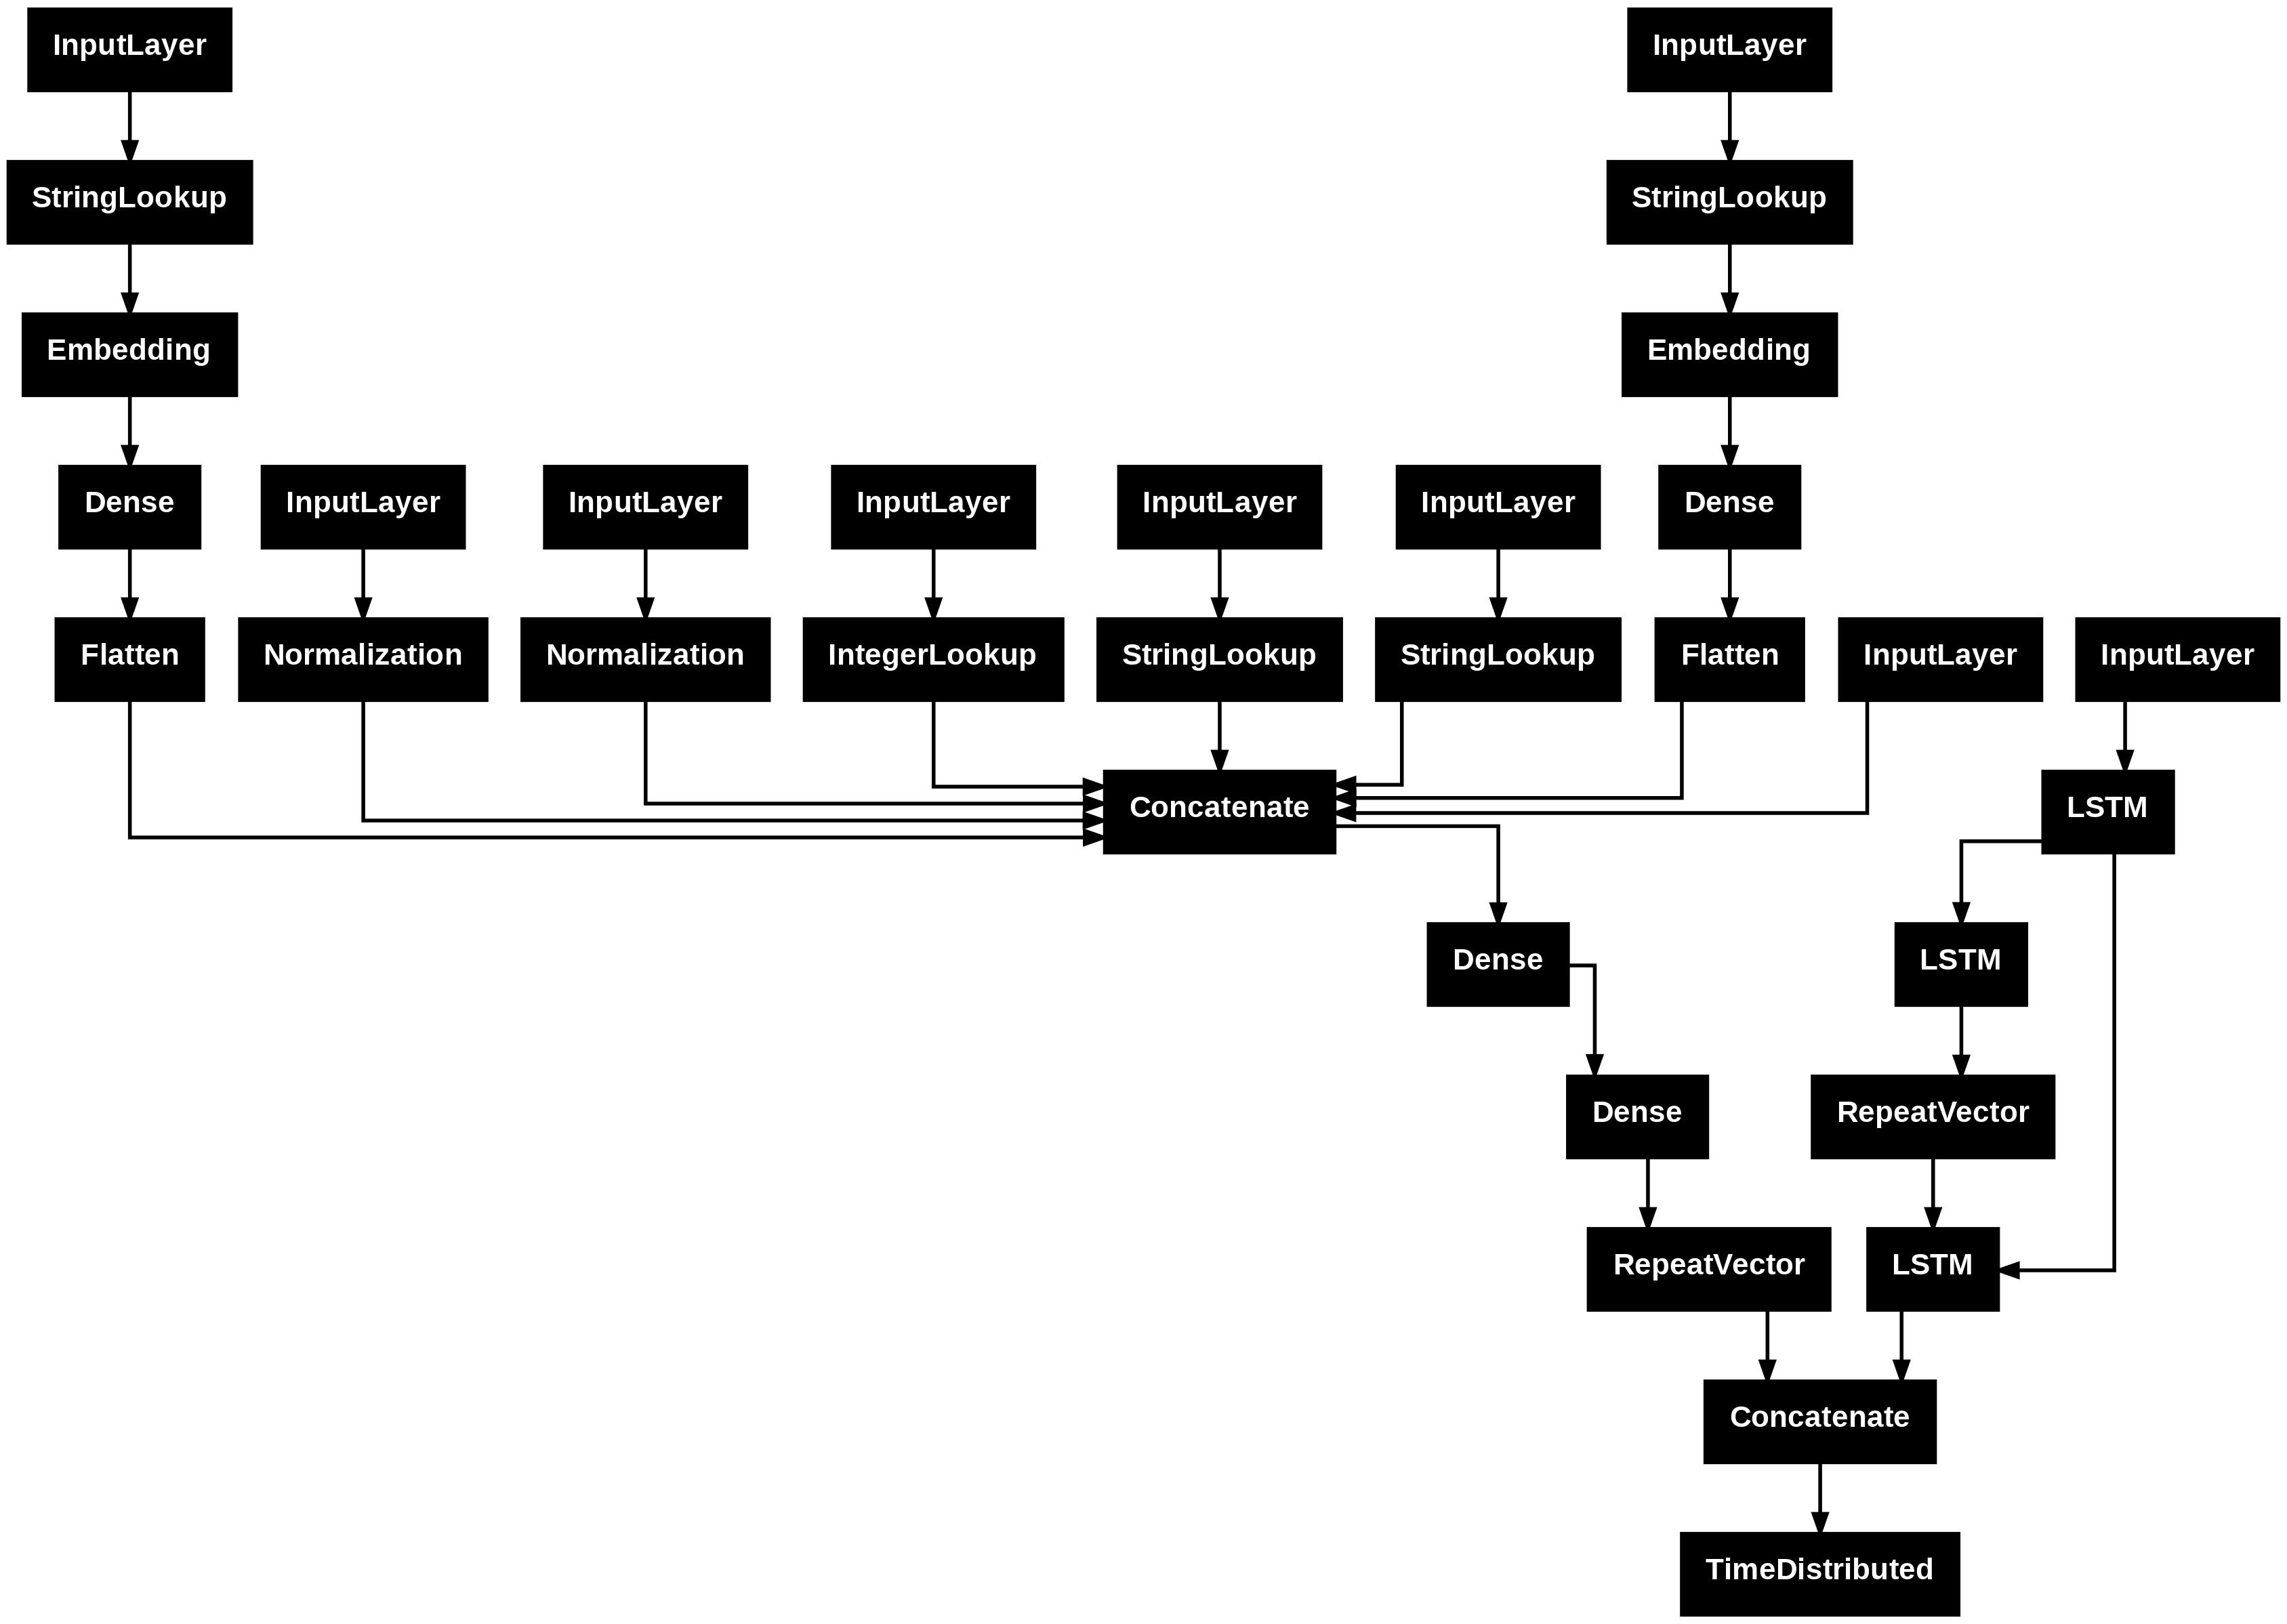

In [26]:
tf.keras.utils.plot_model(model)

## 6. Обучение автоэнкодера

In [27]:
METRICS = [
    tf.keras.metrics.MeanAbsoluteError(name="mae"),
    tf.keras.metrics.MeanAbsolutePercentageError(name="mape"),
    tf.keras.metrics.MeanSquaredError(name="mse"),
    tf.keras.metrics.RootMeanSquaredError(name="rmse")
]

In [28]:
i = 2
model_path = f"models/autoencoder_v{i}.keras"
history_path = f"models/autoencoder_training_history_v{i}.joblib"

disk_path = "/content/drive/MyDrive/ML_projects/08_anomaly_detection/"
checkpoints_path = disk_path + f'data/06_model_output/initial_weights_{i}.weights.h5'

BATCH_SIZE = 128

regenerate = False
if regenerate:
    initial_weights = os.path.join(tempfile.mkdtemp(), checkpoints_path)

    autoencoder = get_model(df_stat, model_type="autoencoder")
    autoencoder.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.Huber(),
        metrics=METRICS
    )
    autoencoder.load_weights(initial_weights)

    n_epochs = 200
    steps_per_epoch= 239
    batch_size = BATCH_SIZE
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 3e-2 * 0.99**epoch
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=30,
        min_delta=1e-06,
        verbose=1,
        mode="min",
        restore_best_weights=True,
    )

    autoencoder_history = autoencoder.fit(
        ds_train.shuffle(5000).batch(batch_size),
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=ds_valid.batch(batch_size),
        batch_size=batch_size,
        verbose=1,
        callbacks=[reduce_lr, early_stopping],
        shuffle=True,
    )
    autoencoder.save(model_path)
    joblib.dump(autoencoder_history, history_path)
else:
    autoencoder = tf.keras.models.load_model(disk_path + model_path)
    autoencoder_history = joblib.load(disk_path + history_path)

In [29]:
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ object_type (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street (InputLayer)       │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ object_type_prep          │ (None, 1)              │              0 │ object_type[0][0]      │
│ (StringLookup)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street_prep               │ (None, 1)              │              0 │ street[0][0]           │
│ (StringLookup)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ object_type_emb           │ (None, 1, 5)           │            110 │ object_type_prep[0][0] │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street_emb (Embedding)    │ (None, 1, 15)          │          3,315 │ street_prep[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ n_floors (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area (InputLayer)         │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area_group (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ object_type_dense (Dense) │ (None, 1, 2)           │             12 │ object_type_emb[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ floor_group (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ year_group (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street_dense (Dense)      │ (None, 1, 8)           │            128 │ street_emb[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ LSTM input (InputLayer)   │ (None, 4, 3)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ n_floors_prep             │ (None, 1)              │              3 │ n_floors[0][0]         │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area_prep (Normalization) │ (None, 1)              │              3 │ area[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area_group_prep           │ (None, 11)             │              0 │ area_group[0][0]       │
│ (IntegerLookup)           │                        │                │                        │
├──────────────────────

 Total params: 24,152 (94.36 KB)

 Trainable params: 8,048 (31.44 KB)

 Non-trainable params: 6 (32.00 B)

 Optimizer params: 16,098 (62.89 KB)

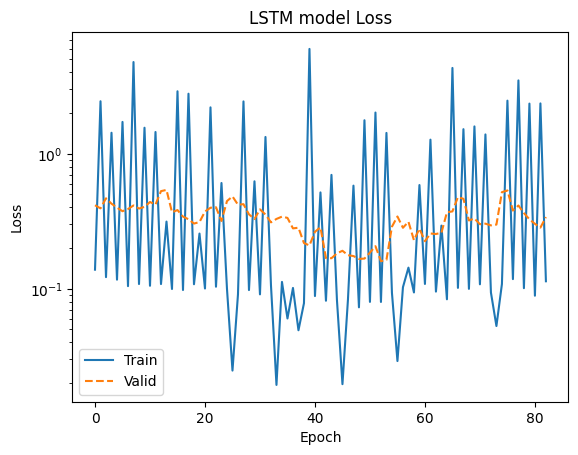

In [30]:
plot_loss(autoencoder_history)

* Модель была предобучена.

In [31]:
results = autoencoder.evaluate(
    ds_train.batch(batch_size=BATCH_SIZE),
    batch_size=BATCH_SIZE,
    verbose=0
)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0766


In [32]:
valid_results = autoencoder.evaluate(
    ds_valid.batch(batch_size=BATCH_SIZE),
    batch_size=BATCH_SIZE,
    verbose=0
)
for name, value in zip(autoencoder.metrics_names, valid_results):
  print(f'{name} : {value}')

loss : 0.15995372831821442
compile_metrics : 0.31891095638275146


In [33]:
test_results = autoencoder.evaluate(
    ds_test.batch(batch_size=BATCH_SIZE),
    batch_size=BATCH_SIZE,
    verbose=0
)
for name, value in zip(autoencoder.metrics_names, test_results):
  print(f'{name} : {value}')

loss : 0.19303925335407257
compile_metrics : 0.3918949365615845


In [34]:
save_weights = False
if save_weights:
  autoencoder.save_weights(checkpoints_path)

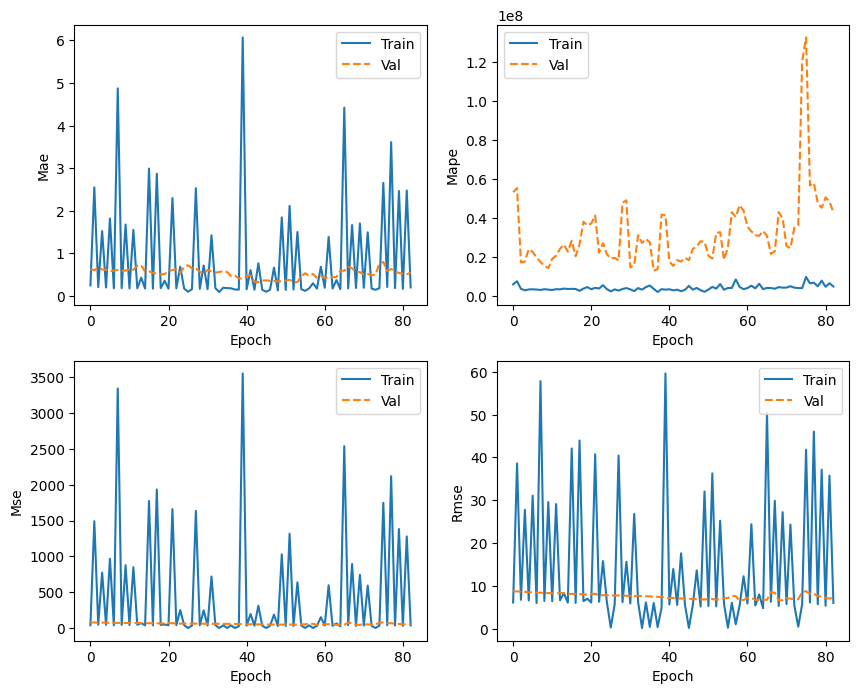

In [35]:
plot_metrics(autoencoder_history)

## 7. Отбор кандидатов для эталонной модели LSTM

Предсказание эталонного текущего значения по трем предшествующим периодам.

In [36]:
results = autoencoder.predict(ds_train.batch(BATCH_SIZE))
results.shape

240/240 ━━━━━━━━━━━━━━━━━━━━ 38s 158ms/step


(30684, 4, 3)

In [37]:
print(f"train_df.shape = {train_df.shape}\n")
train_df.sample(2)

train_df.shape = (30684, 16)



,object index,Адрес объекта 2,Тип объекта,№ ОДПУ,Вид энерг-а ГВС,Этажность объекта,Дата постройки,Общая площадь объекта,Группа этажность объекта,Улица,Дата постройки 2,Группа год постройки,Группа общая площадь объекта,seq index,LSTM input,last seq month
8710,1168,"г Уфа, ул. Блюхера, д.40",Многоквартирный дом,274338,1,5.0,1962-01-01,3441.8,5-9 этажей,ул. Блюхера,1962-01-01,1959-1989 гг.,3800,12,"[(0.892483870967742, 1.0, 0), (0.4919483870967...",2022-10-01
24779,3512,"г Уфа, ул. Рихарда Зорге, д.76",Другое строение,20-117659,1,1.0,1999-01-01,0.0,1-2 этажа,ул. Рихарда Зорге,1999-01-01,1990-2000 гг.,1,2,"[(0.1021875, 1.0, 0), (0.07103448275862069, 0....",2021-12-01


In [38]:
df = train_df["LSTM input"].apply(lambda x: pd.Series(np.array(x).T[0].tolist()))
df.values.shape

(30684, 4)

* Исходим из того, что 30% от выборки, которые плохо поддаются моделированию - аномалии.
* На адекватных 70% обучим эталонную модель предсказания потребления теплоэнергии в четвертом периоде на основе трех предшествующих.

In [39]:
a = abs(df.values - results[:, :, 0]).mean(axis=1) / df.values.mean(axis=1)
q = np.quantile(a, 0.7)
q

0.07051601504242709

* Точка отсечения - абсолютная ошибка предсказания потребления объекта выше 7%

In [40]:
selected_inputs_df = train_df[a < q]

print(f"selected_inputs_df.shape = {selected_inputs_df.shape}\n")
selected_inputs_df.sample(2)

selected_inputs_df.shape = (21479, 16)



,object index,Адрес объекта 2,Тип объекта,№ ОДПУ,Вид энерг-а ГВС,Этажность объекта,Дата постройки,Общая площадь объекта,Группа этажность объекта,Улица,Дата постройки 2,Группа год постройки,Группа общая площадь объекта,seq index,LSTM input,last seq month
7450,1018,"г Уфа, ул. Бабушкина, д.19",Многоквартирный дом,235608,0,9.0,1976-01-01,4636.40,5-9 этажей,ул. Бабушкина,1976-01-01,1959-1989 гг.,5900,1,"[(1.7991290322580646, 0.31116998547132724, 1),...",2022-02-01
25954,3711,"г Уфа, ул. Рудольфа Нуреева, д.10",Многоквартирный дом,282733,1,26.0,2018-11-01,13088.81,13 и более этажей,ул. Рудольфа Нуреева,2018-11-01,2011-2024 гг.,25000,12,"[(0.8202258064516129, 1.0, 0), (0.995806451612...",2022-10-01


## 8. Эталонная модель

In [41]:
MODEL_TYPE = "ethalon_model"

### 8.1. Формирование датасета

In [42]:
valid_et = selected_inputs_df.sample(frac=0.2, random_state=25)
train_ind = list(set(selected_inputs_df.index) - set(valid_et.index))
train_et = selected_inputs_df.loc[train_ind, :]

train_et.shape, valid_et.shape

((17183, 16), (4296, 16))

In [43]:
%%time
model_type = MODEL_TYPE

generator_et = Generator(model_type)
ds_train_et = generator_et.get_tf_dataset(train_et)
ds_valid_et = generator_et.get_tf_dataset(valid_et)

ds_train_et.batch(1).take(1)

CPU times: user 69.3 ms, sys: 3.06 ms, total: 72.3 ms
Wall time: 73.8 ms


<_TakeDataset element_spec=({'n_floors': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'area': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'area_group': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'object_type': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'floor_group': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'year_group': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'street': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'gvs': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'LSTM input': TensorSpec(shape=(None, 3, 3), dtype=tf.float64, name=None)}, TensorSpec(shape=(None, 1, 3), dtype=tf.float64, name=None))>

### 8.2. Модель

In [44]:
model = get_model(selected_inputs_df, model_type)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ object_type (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street (InputLayer)       │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ object_type_prep          │ (None, 1)              │              0 │ object_type[0][0]      │
│ (StringLookup)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street_prep               │ (None, 1)              │              0 │ street[0][0]           │
│ (StringLookup)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ object_type_emb           │ (None, 1, 5)           │             95 │ object_type_prep[0][0] │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street_emb (Embedding)    │ (None, 1, 15)          │          3,135 │ street_prep[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ n_floors (InputLayer)     │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area (InputLayer)         │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area_group (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ object_type_dense (Dense) │ (None, 1, 2)           │             12 │ object_type_emb[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ floor_group (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ year_group (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ street_dense (Dense)      │ (None, 1, 8)           │            128 │ street_emb[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ LSTM input (InputLayer)   │ (None, 3, 3)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ n_floors_prep             │ (None, 1)              │              3 │ n_floors[0][0]         │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area_prep (Normalization) │ (None, 1)              │              3 │ area[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ area_group_prep           │ (None, 11)             │              0 │ area_group[0][0]       │
│ (IntegerLookup)           │                        │                │                        │
├──────────────────────

 Total params: 7,859 (30.71 KB)

 Trainable params: 7,853 (30.68 KB)

 Non-trainable params: 6 (32.00 B)

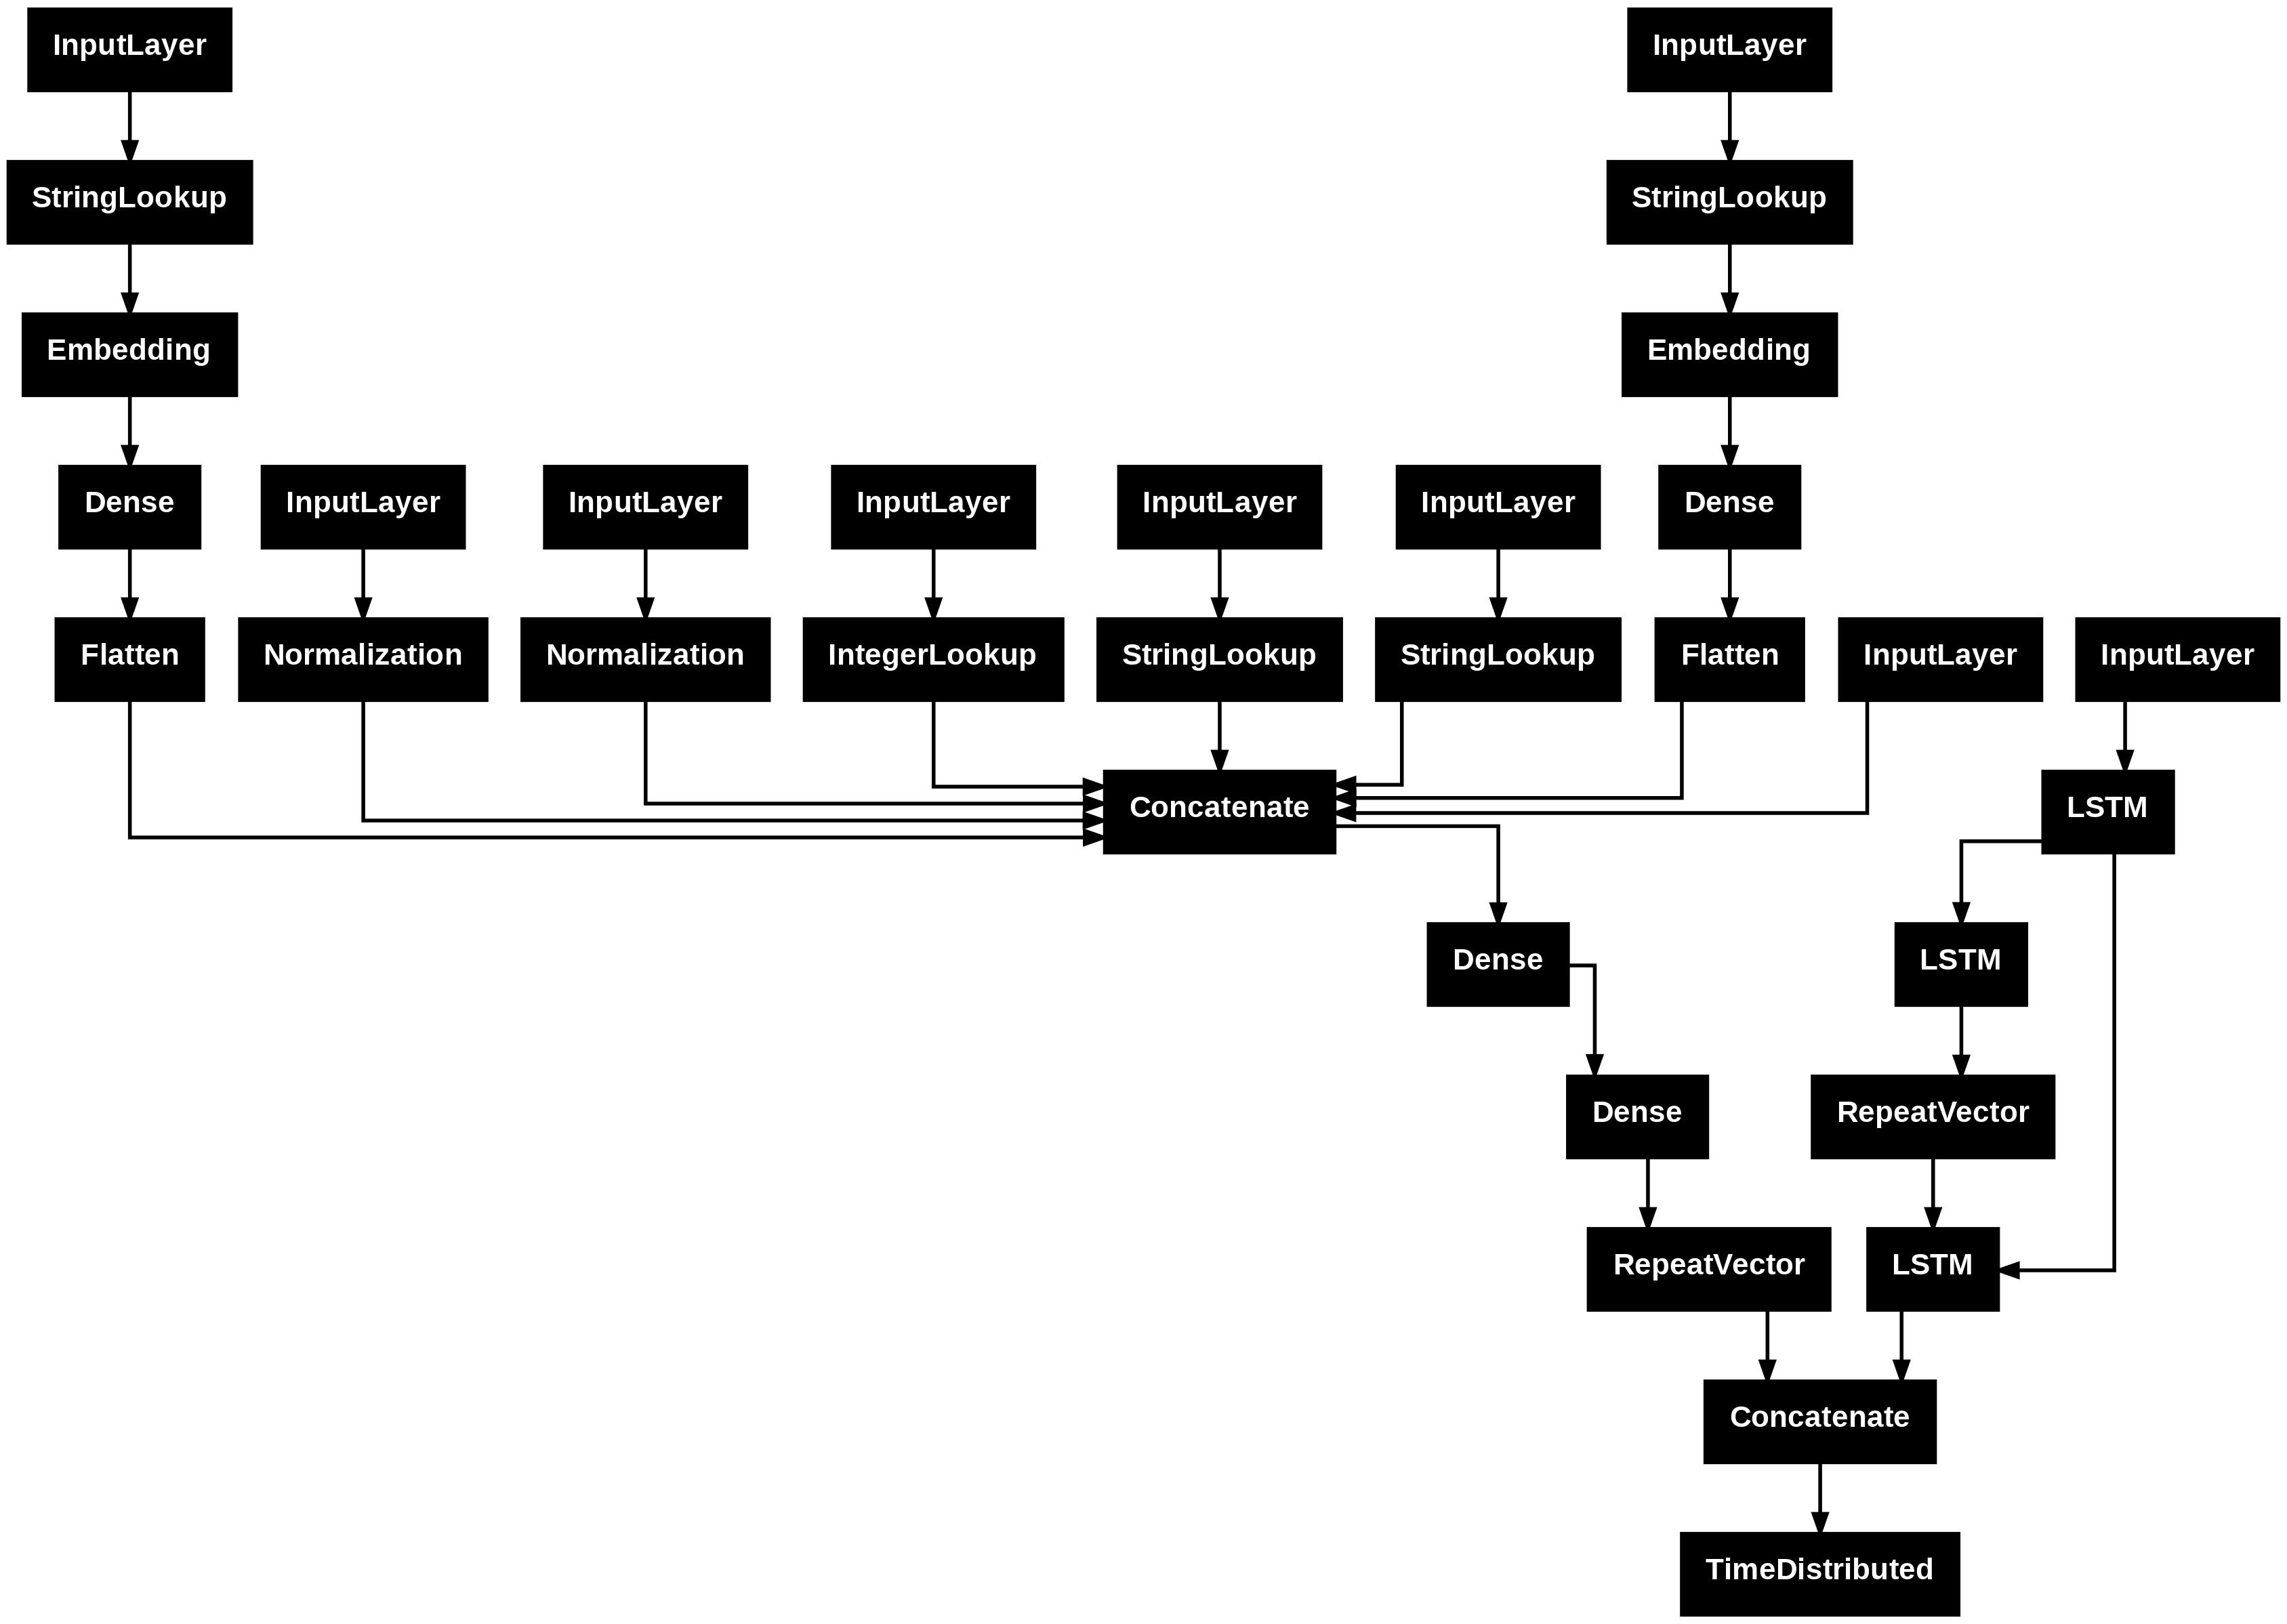

In [45]:
tf.keras.utils.plot_model(model)

### 8.3. Обучение модели

In [46]:
i = 1
model_path = f"models/ethalon_model_v{i}.keras"
history_path = f"models/ethalon_model_training_history_v{i}.joblib"

disk_path = "/content/drive/MyDrive/ML_projects/08_anomaly_detection/"
checkpoints_path = disk_path + f'data/06_model_output/ethalon_model_initial_weights_{i}.weights.h5'

BATCH_SIZE = 128

regenerate = False
if regenerate:
    initial_weights = os.path.join(tempfile.mkdtemp(), checkpoints_path)

    ethalon_model = get_model(selected_inputs_df, model_type)
    ethalon_model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.Huber(),
        metrics=METRICS
    )
    ethalon_model.load_weights(initial_weights)

    n_epochs = 200
    steps_per_epoch = 239
    batch_size = BATCH_SIZE
    reduce_lr = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 3e-2 * 0.99**epoch
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=30,
        min_delta=1e-06,
        verbose=1,
        mode="min",
        restore_best_weights=True,
    )

    ethalon_history = ethalon_model.fit(
        ds_train_et.shuffle(5000).batch(batch_size),
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=ds_valid_et.batch(batch_size),
        batch_size=batch_size,
        verbose=1,
        callbacks=[reduce_lr, early_stopping],
        shuffle=True,
    )
    ethalon_model.save(model_path)
    joblib.dump(ethalon_history, history_path)
else:
    ethalon_model = tf.keras.models.load_model(disk_path + model_path)
    ethalon_history = joblib.load(disk_path + history_path)

### 8.4. Оценка модели

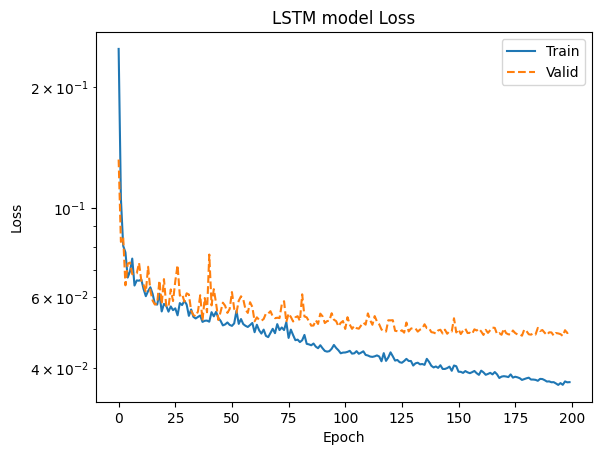

In [47]:
plot_loss(ethalon_history)

In [48]:
results = ethalon_model.evaluate(
    ds_train_et.batch(batch_size=BATCH_SIZE),
    batch_size=BATCH_SIZE,
    verbose=0
)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0357


In [49]:
baseline_results = ethalon_model.evaluate(
    ds_valid_et.batch(batch_size=BATCH_SIZE),
    batch_size=BATCH_SIZE,
    verbose=0
)
for name, value in zip(ethalon_model.metrics_names, baseline_results):
  print(f'{name} : {value}')

loss : 0.048080552369356155
compile_metrics : 0.1143491342663765


In [50]:
save_weights = False
if save_weights:
  ethalon_model.save_weights(checkpoints_path)

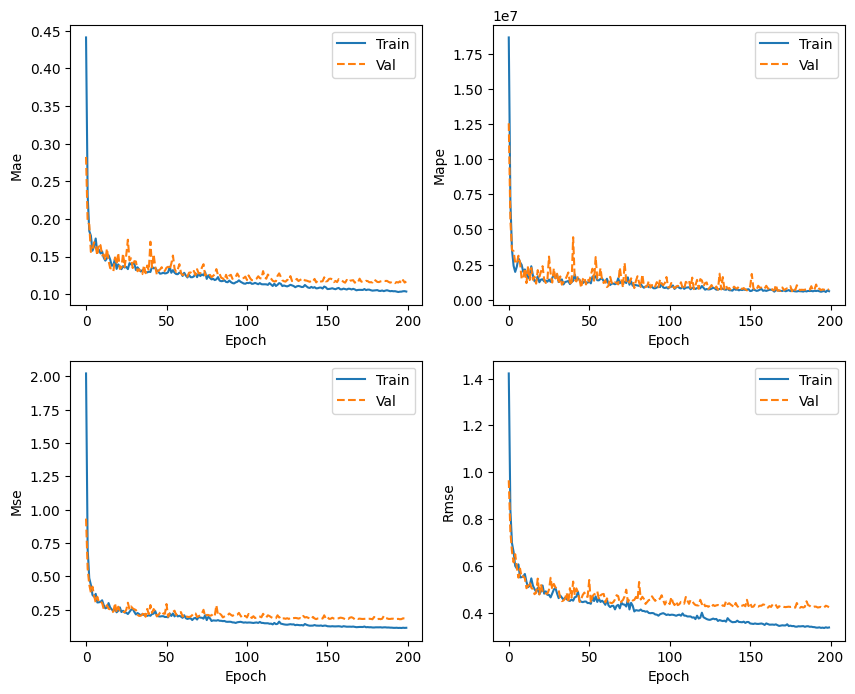

In [51]:
plot_metrics(ethalon_history)

### 8.5. Оценка идеальной модели на валидационном датасете

In [52]:
results_et = ethalon_model.predict(ds_valid_et.batch(BATCH_SIZE))
results_et.shape

34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step


(4296, 1, 3)

In [53]:
%%time
result, model_inputs_df = post_process_inference_results(
     valid_et, results_et, percentile=95
)

CPU times: user 2.55 s, sys: 34.7 ms, total: 2.58 s
Wall time: 2.65 s


In [54]:
info = pd.DataFrame(
    abs(model_inputs_df["Отклонение от прогноза"])
).describe([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, .99])

display(info.style.format({"Отклонение от прогноза":"{:,.3f}"}))

,Отклонение от прогноза
count,"4,296.000"
mean,0.329
std,0.655
min,0.000
10%,0.027
25%,0.066
50%,0.152
75%,0.329
90%,0.699
95%,1.177


In [55]:
print(f"result.shape = {result.shape}")
result.sample(2)

result.shape = (215, 12)


,Адрес объекта 2,Тип объекта,№ ОДПУ,Вид энерг-а ГВС,Этажность объекта,Дата постройки,Общая площадь объекта,Период потребления,Фактическое суточное потребление,Прогноз модели,Отклонение от прогноза,Индекс соответствия прогнозу
15488,"г Уфа, ул. Комсомольская, д.159 корп.1",Многоквартирный дом,4302878,0,7.0,2005-01-01,15365.5,2022-04-01,3.879412,5.710884,-1.831472,0.47210
15328,"г Уфа, ул. Комсомольская, д.139",Многоквартирный дом,711368,1,16.0,2008-01-01,7833.4,2022-02-01,9.102143,7.056797,2.045346,0.22471


## Комментарии

* Модель делает достаточно точные предскания суточного потребления очищенных данных. Аномалии будут вызывать существенное отклонение предсказаний от фактического значения потребления - таким образом, их можно будет выявлять.